[*********************100%***********************]  1 of 1 completed


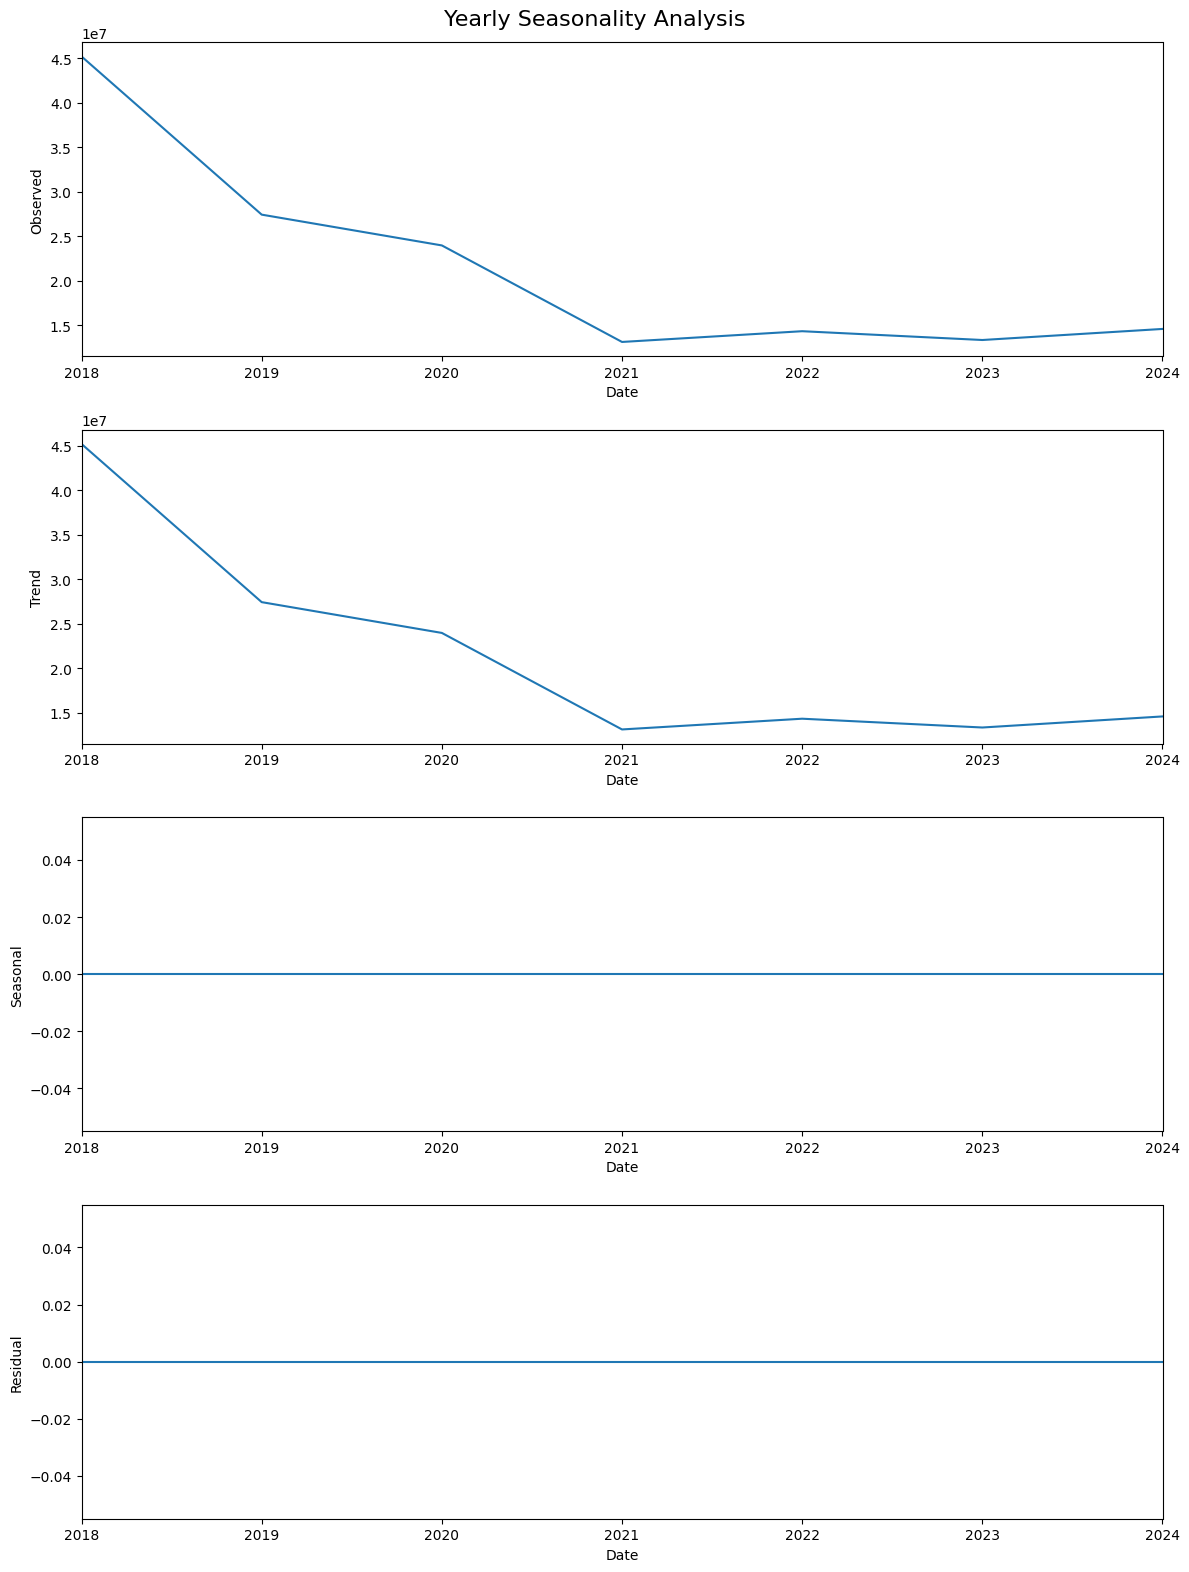

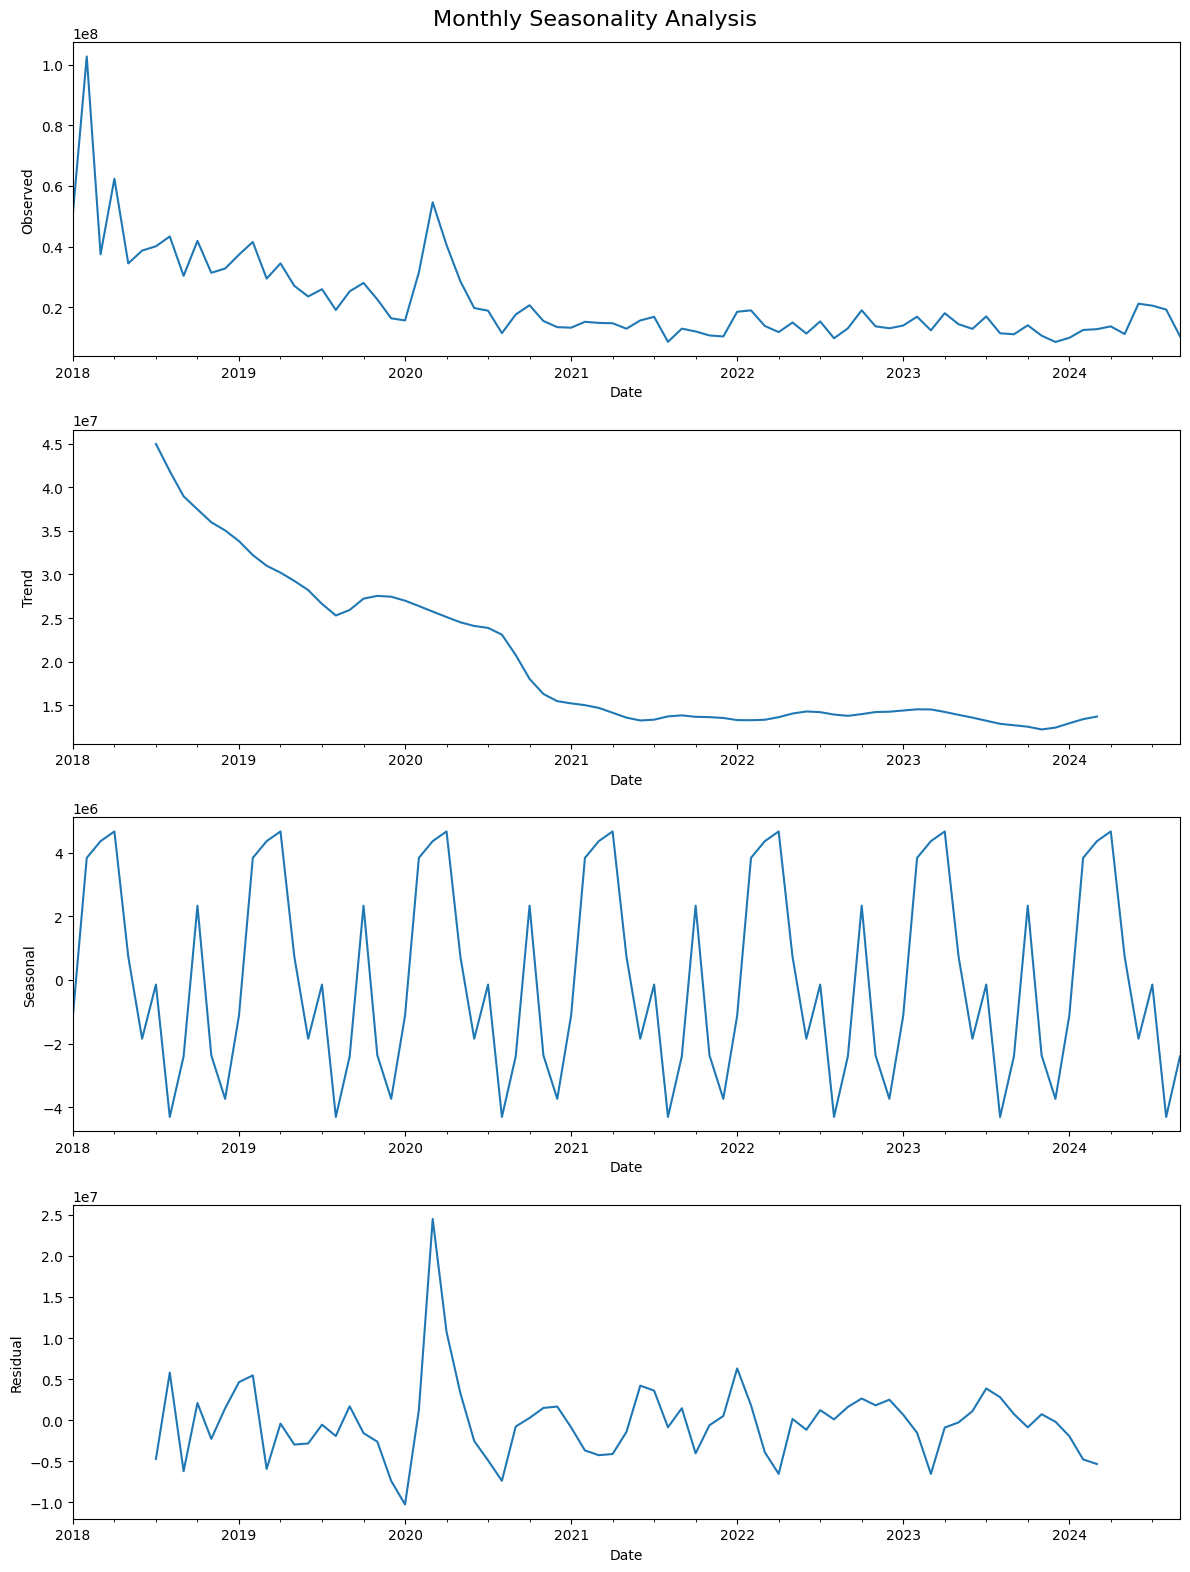

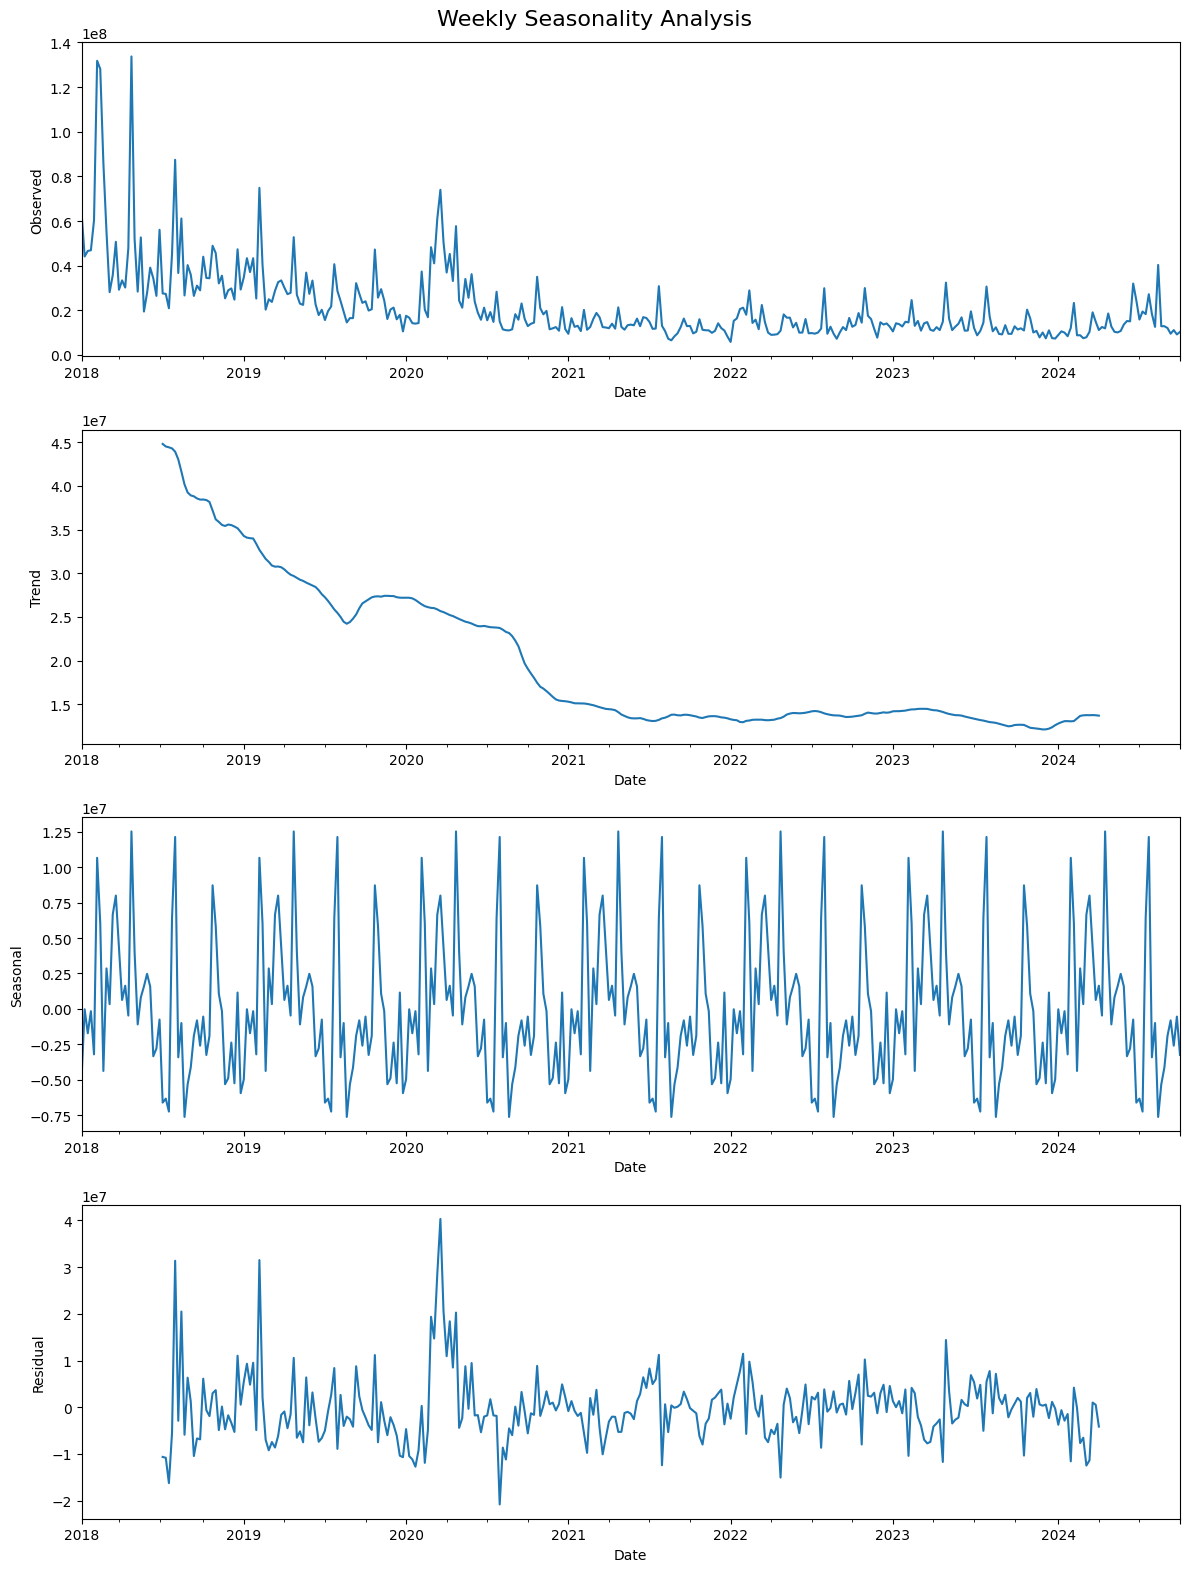


Top 3 months by average trading volume for CMG:
February: 33,998,246
April: 28,074,483
March: 24,848,137


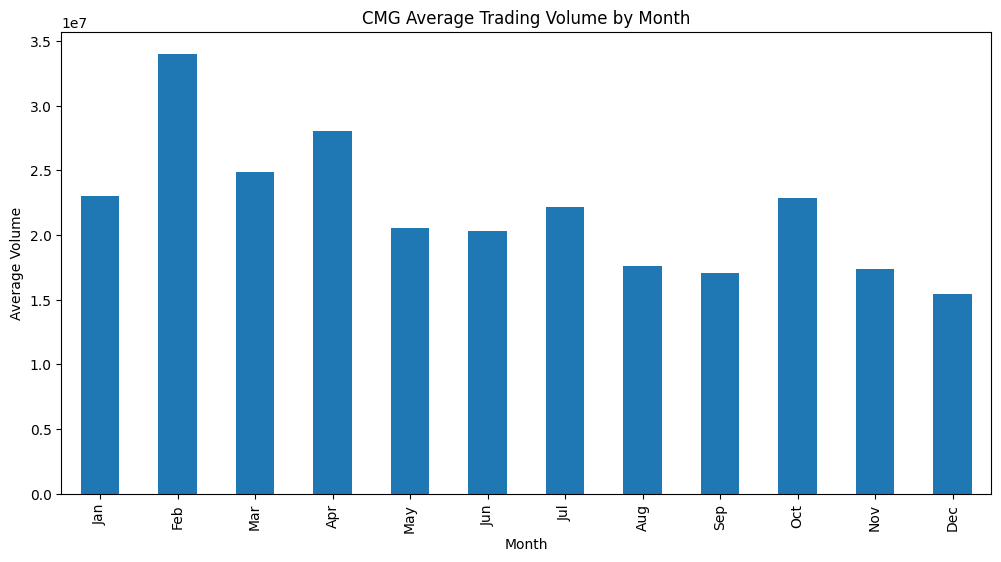

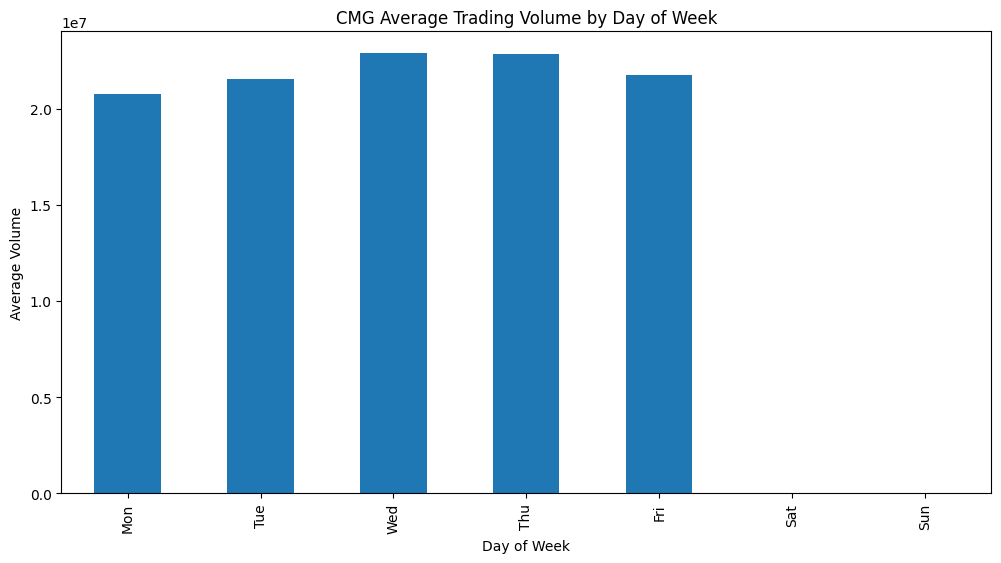

Seasonality analysis complete.


In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

# Download NVDA data
ticker = "CMG"
data = yf.download(ticker, start="2018-01-01", end="2024-10-01")

# Resample data to different frequencies
daily_volume = data['Volume']
weekly_volume = daily_volume.resample('W').mean()
monthly_volume = daily_volume.resample('M').mean()
yearly_volume = daily_volume.resample('Y').mean()

# Function to plot seasonal decomposition
def plot_seasonal_decompose(series, title):
    result = seasonal_decompose(series, model='additive')
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
    fig.suptitle(f'{title} Seasonality Analysis', fontsize=16)
    
    result.observed.plot(ax=ax1)
    ax1.set_ylabel('Observed')
    result.trend.plot(ax=ax2)
    ax2.set_ylabel('Trend')
    result.seasonal.plot(ax=ax3)
    ax3.set_ylabel('Seasonal')
    result.resid.plot(ax=ax4)
    ax4.set_ylabel('Residual')
    
    plt.tight_layout()
    plt.show()

# Yearly seasonality
plot_seasonal_decompose(yearly_volume, 'Yearly')

# Monthly seasonality
plot_seasonal_decompose(monthly_volume, 'Monthly')

# Weekly seasonality
plot_seasonal_decompose(weekly_volume, 'Weekly')

# Calculate average volume by month
monthly_avg = daily_volume.groupby(daily_volume.index.month).mean()
monthly_avg = monthly_avg.reindex(range(1, 13), fill_value=0)

# Sort monthly average volume in descending order and get top 3
top_3_months = monthly_avg.sort_values(ascending=False).head(3)

# Create a dictionary to map month numbers to month names
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

# Print the top 3 months by average volume
print(f"\nTop 3 months by average trading volume for {ticker}:")
for month, volume in top_3_months.items():
    print(f"{month_names[month]}: {volume:,.0f}")


# Plot average volume by month
plt.figure(figsize=(12, 6))
monthly_avg.plot(kind='bar')
plt.title(f'{ticker} Average Trading Volume by Month')
plt.xlabel('Month')
plt.ylabel('Average Volume')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Calculate average volume by day of week
weekday_avg = daily_volume.groupby(daily_volume.index.dayofweek).mean()
weekday_avg = weekday_avg.reindex(range(7), fill_value=0)

# Plot average volume by day of week
plt.figure(figsize=(12, 6))
weekday_avg.plot(kind='bar')
plt.title(f'{ticker} Average Trading Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Volume')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

print("Seasonality analysis complete.")


In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Assuming 'data' is your DataFrame with OHLCV data
# If not, you'll need to load your data here

# Calculate VWAP
data['VWAP'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()

# Create a new column for the anchored VWAP
data['Anchored_VWAP'] = None

# Find all May 1st dates
may_dates = data.index[data.index.month == 5].tolist()

# Calculate anchored VWAP for each period starting from May
for i in range(len(may_dates)):
    start_date = may_dates[i]
    end_date = may_dates[i+1] if i+1 < len(may_dates) else data.index[-1]
    
    period_data = data.loc[start_date:end_date]
    period_vwap = (period_data['Close'] * period_data['Volume']).cumsum() / period_data['Volume'].cumsum()
    
    data.loc[start_date:end_date, 'Anchored_VWAP'] = period_vwap

# Create the candlestick chart with anchored VWAP
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.03, subplot_titles=(f'{ticker} Price', 'Volume'),
                    row_heights=[0.7, 0.3])

# Add candlestick trace
fig.add_trace(go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name='Price'),
                row=1, col=1)

# Add anchored VWAP trace
fig.add_trace(go.Scatter(x=data.index, y=data['Anchored_VWAP'],
                         mode='lines', name='Anchored VWAP',
                         line=dict(color='purple', width=1)),
                row=1, col=1)

# Add volume bar chart
fig.add_trace(go.Bar(x=data.index, y=data['Volume'], name='Volume'),
              row=2, col=1)

# Update layout
fig.update_layout(
    title=f'{ticker} Price with Anchored VWAP',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    height=800,
    showlegend=False
)

# Show the plot
fig.show()


In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# Assuming 'data' is your DataFrame with OHLCV data and datetime index

# Identify the anchor dates (end of May, November, and February)
data['Year'] = data.index.year
data['Month'] = data.index.month

anchor_months = [2, 5, 11]  # February, May, November
anchor_dates = []

for y in data['Year'].unique():
    for m in anchor_months:
        month_data = data[(data['Year'] == y) & (data['Month'] == m)]
        if not month_data.empty:
            last_date = month_data.index.max()
            anchor_dates.append(last_date)

# Sort the anchor dates
anchor_dates = sorted(anchor_dates)

# Initialize columns for Anchored VWAPs
data['Anchored_VWAP'] = np.nan
data['VWAP_Color'] = np.nan  # To store color codes

# Define color mapping for periods
colors = ['purple', 'orange', 'green']

# Calculate anchored VWAP for each period starting from the anchor dates
for i in range(len(anchor_dates)):
    start_date = anchor_dates[i]
    end_date = anchor_dates[i+1] if i+1 < len(anchor_dates) else data.index[-1]
    
    period_data = data.loc[start_date:end_date]
    period_vwap = ((period_data['Close'] * period_data['Volume']).cumsum() /
                   period_data['Volume'].cumsum())
    
    data.loc[start_date:end_date, 'Anchored_VWAP'] = period_vwap
    data.loc[start_date:end_date, 'VWAP_Color'] = i % 3  # Assign a color code

# Map color codes to actual colors
data['VWAP_Color'] = data['VWAP_Color'].map({0: colors[0], 1: colors[1], 2: colors[2]})

# Create the candlestick chart with anchored VWAP
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.03, subplot_titles=('Price', 'Volume'),
                    row_heights=[0.7, 0.3])

# Add candlestick trace
fig.add_trace(go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name='Price'),
                row=1, col=1)

# Add anchored VWAP trace with varying colors
fig.add_trace(go.Scatter(x=data.index, y=data['Anchored_VWAP'],
                         mode='lines', name='Anchored VWAP',
                         line=dict(width=2, color='rgba(0,0,0,0)'),  # Invisible line
                         hoverinfo='skip'),
                row=1, col=1)

# Add segments with different colors
for i in range(len(anchor_dates)):
    start_date = anchor_dates[i]
    end_date = anchor_dates[i+1] if i+1 < len(anchor_dates) else data.index[-1]
    period_data = data.loc[start_date:end_date]
    fig.add_trace(go.Scatter(x=period_data.index, y=period_data['Anchored_VWAP'],
                             mode='lines', line=dict(color=colors[i % 3], width=2),
                             showlegend=False),
                  row=1, col=1)

# Add volume bar chart
fig.add_trace(go.Bar(x=data.index, y=data['Volume'], name='Volume'),
              row=2, col=1)

# Update layout
fig.update_layout(
    title='Price with Anchored VWAP',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    height=800,
    showlegend=False
)

# Show the plot
fig.show()
